# LEAP Model Validation

This notebook presents validation results for the `LEAP(Lifetime Exposures and Asthma outcomes Projection)`
model. The objective is to compare key simulated outputs from the current pythonic version to
observed targets. The taregts include demographic trends, asthma prevalence and incidence,
risk factor distributions, and asthma-related health outcomes.

A large sample run of `LEAP` was used to generate all of the data files used in this notebook.


## Notebook setup

### Environment setup

In [195]:
# Environment setup
%load_ext autoreload
%autoreload 2

import plotly.io as pio
# pio.renderers.default = "sphinx_gallery"
import plotly.express as px
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from leap.data_generation.exacerbation_data import load_population_data
from leap.utils import get_data_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Plot Settings
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 16
pio.templates.default = "plotly_white"
config = {
    'toImageButtonOptions': {
        'format': 'png',
        'height': 600,
        'width': 1000,
        'scale': 2
    }
}

### Running Simulation to Obtain Data

*Currently, simulations at a sufficient size to get meaningful results take too long to run*
*practically in the notebook. So calling simulation.run() in the Jupyter notebook and using the*
*generated outcome_matrix object for analysis is infeasible. Instead, run it seperately from the*
*command line and use the outputted csvs.*

To run the simulation, open a terminal:

```sh
leap
    --run-simulation
    --path-output PATH/TO/SAVE/OUTPUT/
    --province PROVINCE
    --max-age MAX_AGE
    --min-year STARTING_YEAR
    --time-horizon SIMULATION_LENGTH
    --population-growth-type GROWTH_TYPE
    --num-births-initial N_BIRTHS
    --ignore-pollution
```

**NOTE**: The default simulation folder naming scheme is:

`./leap_output/PROVINCE-MAX_AGE-STARTING_YEAR-SIMULATION_LENGTH-GROWTH_TYPE-N_BIRTHS`

For instance, if the model was run with the following parameters:

```json
"parameters": {
        "province": "CA",
        "max_age": 100,
        "min_year": 2001,
        "time_horizon": 15,
        "population_growth_type": "M3",
        "num_births_initial": 5000,
        "pollution ignored": true,
        "max_year": 2015
    }
```

Then the deafult folder name would be:

``./leap_output/CA-100-2001-15-M3-5000``

### Constants and Parameters

In [3]:
# Constants for this notebook
notebook_path = Path(os.getcwd())
LEAP_ROOT = notebook_path.parent.parent

# Simulation parameters
RUN_BUNDLE_NAME = "sample_leap_output"
PROVINCE = "CA"
MAX_AGE = 110
STARTING_YEAR = 2001
SIMULATION_LENGTH = 30
GROWTH_TYPE = "M3"
N_BIRTHS = 5000

# Replace with the path to the folder containing your LEAP output csvs
RUN_BUNDLE_FOLDER = LEAP_ROOT / "leap" / "sample_leap_output"

if RUN_BUNDLE_FOLDER.exists():
    print(f"Run bundle folder found at {RUN_BUNDLE_FOLDER.relative_to(LEAP_ROOT)}")
else:
    raise FileNotFoundError(f"!! Run bundle folder does not exist {RUN_BUNDLE_FOLDER}")

Run bundle folder found at leap/sample_leap_output


## Mortality Figure

Mortality by sex (left: males; right: females) for the model (grey solid) and Statistics
Canada (black dashed).

### Load Data

In [4]:
# Read observed StatCan mortality data
target_mortality_df_raw = pd.read_csv(get_data_path("processed_data/life_table.csv"))

# Read mortality data from simulation
model_mortality_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")

# Read population data from simulation
model_alive_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [5]:
# Filter by ages under 80 years for the figure
target_mortality_df = target_mortality_df_raw[target_mortality_df_raw["age"] <= 80]
# Filter by chosen province
target_mortality_df = target_mortality_df[target_mortality_df["province"] == PROVINCE]

# Filter by ages under 80 years for the figure
model_mortality_df = model_mortality_df_raw[model_mortality_df_raw["age"] <= 80]
# Merge model_mortality_df with model_alive_df to get n_alive for each row
model_mortality_df = model_mortality_df.merge(model_alive_df_raw, on=["year", "age", "sex"])
# Calculate mortality rate as n_deaths / n_alive
model_mortality_df["prob_death"] = model_mortality_df["n_deaths"] / model_mortality_df["n_alive"]

### Visualize Data

In [6]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

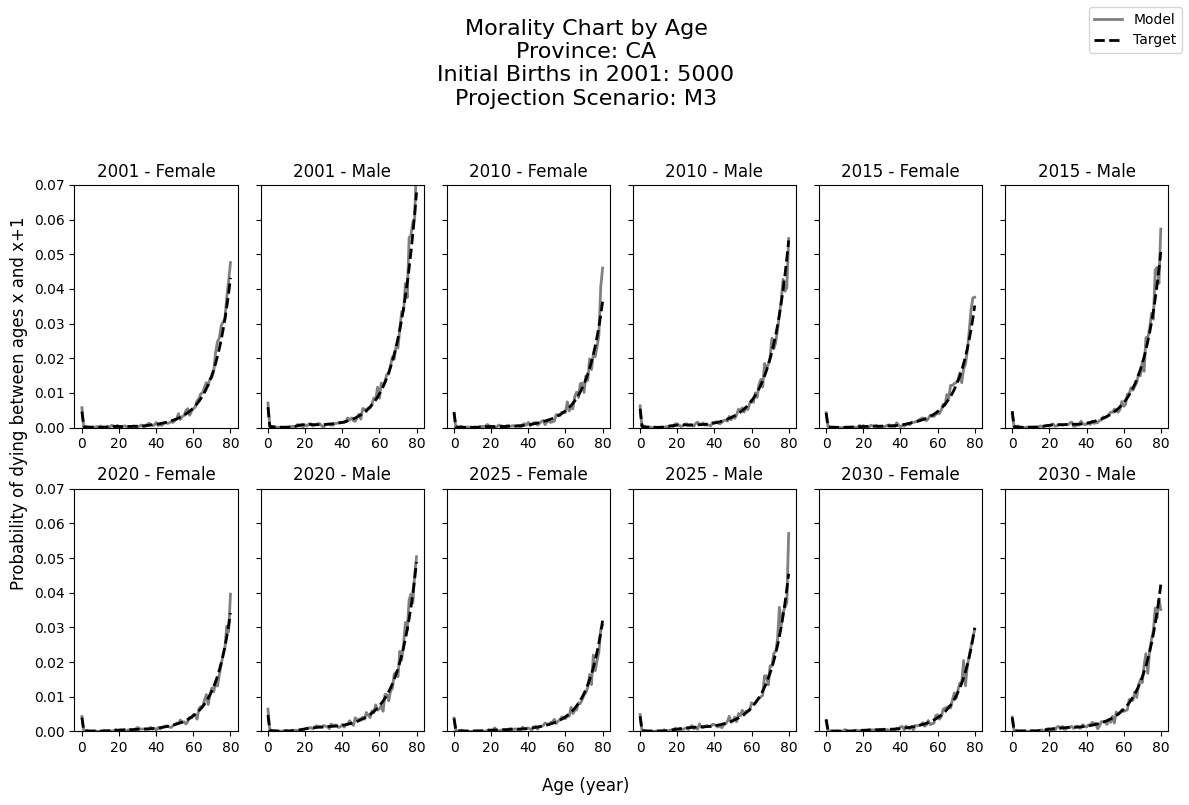

In [7]:
fig, axs = plt.subplots(
    nrows=num_rows, ncols=num_cols * 2, figsize=(4 * num_cols, 4 * num_rows), sharey=True
)

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    for j, sex in enumerate(["F", "M"]):
        # Get axis for current plot by indexing with i and j
        if num_rows == 1:
            ax: plt.Axes = axs[i * 2 + j] if num_cols == 1 else axs[i * 2 + j]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols * 2 + j]

        # Filter StatsCan data by current year and sex
        target_mortality_filtered_df = target_mortality_df[
            (target_mortality_df["year"] == year) & (target_mortality_df["sex"] == sex)
        ]
        # Filter simulation data by current year and sex
        model_mortality_filtered_df = model_mortality_df[
            (model_mortality_df["year"] == year) & (model_mortality_df["sex"] == sex)
        ]

        # Plot mortality trend from the model
        ax.plot(
            model_mortality_filtered_df["age"],
            model_mortality_filtered_df["prob_death"],
            color="grey",
            linewidth=2,
        )
        # Plot mortality trend from target
        ax.plot(
            target_mortality_filtered_df["age"],
            target_mortality_filtered_df["prob_death"],
            color="black",
            linestyle="dashed",
            linewidth=2,
        )

        # Set title and axis limits
        ax.set_title(f"{year} - {'Female' if sex == 'F' else 'Male'}")
        ax.set_ylim(0, 0.07)
        ax.set_xticks([0, 20, 40, 60, 80])

# Additional figure details
fig.supxlabel("Age (year)")
fig.supylabel("Probability of dying between ages x and x+1")
fig.suptitle(
    f"Morality Chart by Age\n"
    + f"Province: {PROVINCE}\n"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"
    + f"Projection Scenario: {GROWTH_TYPE}"
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

## Population Pyramid Figure

Population by age across selected years from the model (grey solid) and from Statistics
Canada (black dashed).

### Load Data

In [130]:
# Read population data from StatCan
target_pop_df_raw = load_population_data(
    province=PROVINCE,
    starting_year=STARTING_YEAR,
    projection_scenario=GROWTH_TYPE,
    min_age=0,
    max_age=MAX_AGE,
    max_year=STARTING_YEAR + SIMULATION_LENGTH - 1
)

# Read population data from simulation
model_pop_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [ ]:
# Rename target column for clarity
target_pop_df = target_pop_df_raw.rename(columns={"n": "n_alive_target"})

# Filter to only include dates after chosen starting year
model_pop_df = model_pop_df_raw[model_pop_df_raw["year"] >= STARTING_YEAR]
# Rename model column for clarity
model_pop_df = model_pop_df.rename(columns={"n_alive": "n_alive_model"})

# Merge the filtered Canada population data and simulation population data
population_df = pd.merge(target_pop_df, model_pop_df, on=["year", "age", "sex"])

# Calculate the scale factor to set the initial population in the model to match the target
total_target = population_df.groupby(["year"])["n_alive_target"].agg("sum").reset_index()
total_target = total_target[total_target["year"] == STARTING_YEAR]["n_alive_target"].values[0]
total_model = population_df.groupby(["year"])["n_alive_model"].agg("sum").reset_index()
total_model = total_model[total_model["year"] == STARTING_YEAR]["n_alive_model"].values[0]
scale_factor = total_target / total_model
population_df["n_alive_model"] *= scale_factor
population_df.reset_index(inplace=True, drop=True)

# Sum over the sex column
population_df = population_df.groupby(["year", "age"]).agg(
    n_alive_target=("n_alive_target", "sum"),
    n_alive_model=("n_alive_model", "sum")
).reset_index()

### Visualize Data

In [194]:
df = population_df.copy()
YEARS = [STARTING_YEAR, 2010, 2015, 2020, 2025, 2030]
df = df[df["year"].isin(YEARS)].reset_index(drop=True)
fig = px.line(
    df,
    x="age",
    y="n_alive_model",
    facet_col="year",
    facet_col_wrap=3,
    title=f"Population Pyramid Comparison<br>"
    + f"Province: {PROVINCE}<br>"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}<br>"
    + f"Projection Scenario: {GROWTH_TYPE}",
    labels={"n_alive_model": "Population"},
    color_discrete_sequence=["#999999"],
    height=800,
    facet_row_spacing=0.15
)
fig_target = px.line(
    df,
    x="age",
    y="n_alive_target",
    facet_col="year",
    facet_col_wrap=3,
    labels={"n_alive_target": "Population"},
    color_discrete_sequence=["black"],
    line_dash_sequence=["dash"],
    height=800,
    facet_row_spacing=0.15
)
fig.add_traces(
    fig_target.data
)

fig.data[0].update(showlegend=True, name="model")
fig.data[len(YEARS)].update(showlegend=True, name="target")
fig.update_xaxes(title_text="Age (years)")
fig.update_layout(
    legend_title_text="",
    title_x=0.5,
    title_y=0.95,
    margin=dict(t=150), # Adjust top margin for title
    showlegend=True
)
fig.show(config=config)

## Infant Antibiotic Exposure Figure

Rate of infant antibiotic prescriptions by sex (red: females; blue: males) for simulated
(solid) and target (dotted) values from the model and the population-based administrative
database, respectively, with the floor rate of 50 per 1000 (purple).

### Load Data

In [11]:
# Load antibiotic data from BC Ministry of Health
target_abx_df = pd.read_csv(get_data_path("processed_data/InfantAbxBC.csv"))

# Load antibiotic data from simulation
model_abx_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_antibiotic_exposure.csv")

# Load additional simulation data for population comparisson
model_infant_alive_df_raw =pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")
model_infant_death_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")
model_infant_emigration_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_emigration.csv")

### Process Data

In [12]:
# Merge all datasets on Year, Sex, and Age
model_abx_df = model_abx_df_raw.rename(columns={'n_antibiotic_exposure': 'n'}).merge(
    model_infant_alive_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_death_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_emigration_df_raw, on=['year', 'sex', 'age']
)

# Filter for age 0
model_abx_df = model_abx_df[model_abx_df['age'] == 0].copy()

# Compute total population (N) and rate per 1000
model_abx_df["N"] = model_abx_df["n_alive"] + model_abx_df["n_deaths"] + model_abx_df["n_emigrants"]
model_abx_df["rate"] = (model_abx_df["n"] / model_abx_df["N"]) * 1000

# Map sex values for labelling
model_abx_df["sex"] = model_abx_df["sex"].map({"F": "Female", "M": "Male"})

### Visualize Data

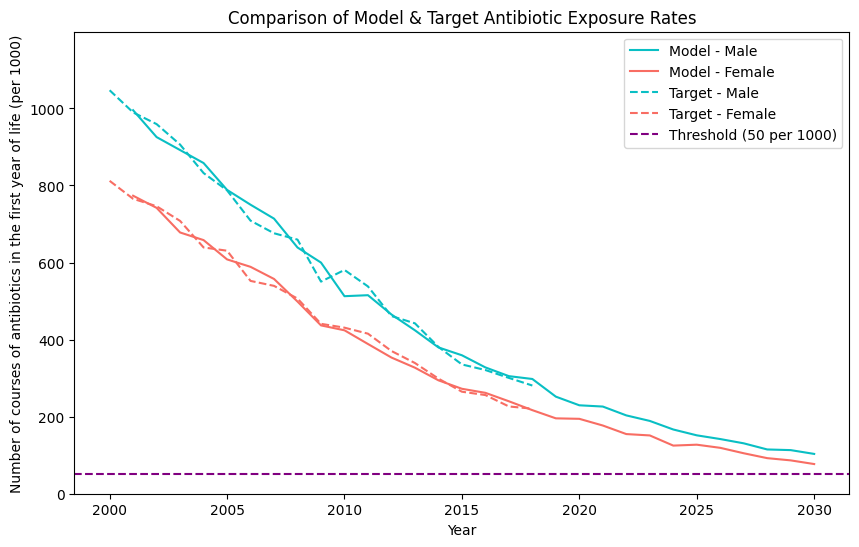

In [13]:
# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}


plt.figure(figsize=(10, 6))

# Plot inftant abx data from simulation
for sex in ["Male", "Female"]:
    subset = model_abx_df[model_abx_df["sex"] == sex]
    plt.plot(subset["year"], subset["rate"],
             label=f"Model - {sex}", color=sex_colour_dict[sex])

# Plot target infant abx data
for sex in ["Male", "Female"]:
    subset = target_abx_df[target_abx_df["sex"] == sex]
    plt.plot(subset["year"], subset["rate"], linestyle="dashed",
             label=f"Target - {sex}", color=sex_colour_dict[sex])

# Add horizontal reference line
plt.axhline(y=50, color="purple", linestyle="dashed", label="Threshold (50 per 1000)")

# Labels, legend, and formatting
plt.xlabel("Year")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1000)")
plt.ylim(0, 1199)
plt.legend()
plt.title("Comparison of Model & Target Antibiotic Exposure Rates")

plt.show()

## Asthma Control Level Figure

Asthma control levels by the model (solid) and target (dashed):

1. <span style="color: blue;">blue: well-controlled</span>
2. <span style="color: orange;">orange: partially-controlled</span>
3. <span style="color: red;">red: uncontrolled</span>

### Load Data

In [17]:
# Read in simulation control data
df_model_control = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_control.csv")

### Process Data

In [18]:
# Validation parameters
TARGET_CONTROL = {
    "uncontrolled": 0.18,
    "partially_controlled": 0.47,
    "well_controlled": 0.35
}

categories = ["uncontrolled", "partially_controlled", "well_controlled"]

df_model_control = df_model_control.groupby(["year", "level"])

# Sum over the probabilities for each control level and year
df_model_control = df_model_control.aggregate({
    "prob": "sum"
}).reset_index().pivot(index="year", columns="level", values="prob").rename(
    columns={0: "well_controlled", 1: "partially_controlled", 2: "uncontrolled"}
).reset_index().rename_axis(None, axis=1)

# Normalize by year
df_model_control["total"] = df_model_control.apply(
    lambda x: x["uncontrolled"] + x["partially_controlled"] + x["well_controlled"], axis=1
)
for level in categories:
    df_model_control[level] /= df_model_control["total"]

# Melt the DataFrame to long format for plotting
df_model_control = df_model_control.melt(
    id_vars=["year"],
    value_vars=categories,
    var_name="control_level",
    value_name="prob"
)

### Visualize Data

In [19]:
color_map={
    "well_controlled": "blue",
    "partially_controlled": "darkorange",
    "uncontrolled": "red"
}

fig = px.line(
    df_model_control,
    x="year",
    y="prob",
    color="control_level",
    title="Asthma Control over Time",
    color_discrete_map=color_map
)

fig.for_each_trace(lambda t: t.update(name=t.name.replace("_", " ") + " model"))
for level in categories:
    fig.add_hline(
        y=TARGET_CONTROL[level],
        line_dash="dash",
        line_color=color_map[level],
        showlegend=True,
        name=level.replace("_", " ") + " target"
    )

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Proportion of Time Spent in Asthma Control Level", range=[0, 1])
fig.update_layout(
    legend_title_text="Control Level",
    title_x=0.5,
    title_y=0.95
)
fig.show(config=config)

## Asthma Exacerbation Severity Figure

Simulated (solid) and target (dotted) asthma exacerbation severity levels:

1. <span style="color: blue;">blue: mild</span>
2. <span style="color: green;">green: moderate</span>
3. <span style="color: orange;">orange: severe</span>
4. <span style="color: red;">red: very severe</span>

### Load Data

In [20]:
# Read in simulation control data
df_model_exac_severity = pd.read_csv(
    RUN_BUNDLE_FOLDER / "outcome_matrix_exacerbation_by_severity.csv"
)

### Process Data

In [21]:
# Validation parameters
TARGET_EXAC_SEVERITY = {
    "mild": 0.495,
    "moderate": 0.195,
    "severe": 0.283,
    "very_severe": 0.026
}

categories = ["mild", "moderate", "severe", "very_severe"]

df_model_exac_severity = df_model_exac_severity.groupby(["year", "severity"])

# Sum over the probabilities for each exacerbation severity and year
df_model_exac_severity = df_model_exac_severity.aggregate({
    "p_exacerbations": "sum"
}).reset_index().pivot(index="year", columns="severity", values="p_exacerbations").rename(
    columns={0: "mild", 1: "moderate", 2: "severe", 3: "very_severe"}
).reset_index().rename_axis(None, axis=1)

# Normalize by year
df_model_exac_severity["total"] = df_model_exac_severity.apply(
    lambda x: x["mild"] + x["moderate"] + x["severe"] + x["very_severe"], axis=1
)

for severity in categories:
    df_model_exac_severity[severity] /= df_model_exac_severity["total"]

# Melt the DataFrame to long format for plotting
df_model_exac_severity = df_model_exac_severity.melt(
    id_vars=["year"],
    value_vars=categories,
    var_name="severity",
    value_name="p_exacerbation"
)
    

### Visualize Data

In [22]:
color_map={
    "mild": "blue",
    "moderate": "green",
    "severe": "darkorange",
    "very_severe": "red"
}
fig = px.line(
    df_model_exac_severity,
    x="year",
    y="p_exacerbation",
    color="severity",
    title="Exacerbation Severity over Time",
    color_discrete_map=color_map
)

fig.for_each_trace(lambda t: t.update(name=t.name.replace("_", " ") + " model"))
for severity in categories:
    fig.add_hline(
        y=TARGET_EXAC_SEVERITY[severity],
        line_dash="dash",
        line_color=color_map[severity],
        showlegend=True,
        name=severity.replace("_", " ") + " target"
    )

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Proportion of Exacerbations by Severity", range=[0, 1])
fig.update_layout(
    legend_title_text="Exacerbation Severity",
    title_x=0.5,
    title_y=0.95
)
fig.show(config=config)

## Very Severe (Hospitalizations) Figure

Comparison of simulated (grey solid) and target (black dotted) very severe asthma
exacerbations (asthma-related hospital admissions) per `100 000` general population by sex (left:
females; right: males) across years.

### Load Data

In [54]:
# Load in hospitalization from target (CIHI)
target_hosp_df_raw = pd.read_csv(
    get_data_path(f"original_data/asthma_hosp/{PROVINCE}/tab1_rate.csv")
)

# Load hospitalization data from simulation
model_hosp_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_exacerbation_hospital.csv")

### Process Data

In [55]:
target_hosp_df = target_hosp_df_raw[["fiscal_year", "F", "M"]]

# Rename fiscal_year to match model
target_hosp_df = target_hosp_df.rename(columns={"fiscal_year": "year"})

# Filter fo years larger than starting year
target_hosp_df = target_hosp_df[target_hosp_df["year"] >= STARTING_YEAR]

# Melt DF to combine M and F columns into sex column
target_hosp_df = target_hosp_df.melt(id_vars='year', var_name='sex', value_name='rate')

# Drop missing or non-positive rows
target_hosp_df = target_hosp_df.dropna(subset=["rate"])

# Get total population in model for current year, age, sex
model_hosp_df = model_hosp_df_raw.merge(model_alive_df_raw, on=["year", "age", "sex"])

# Group columns to get some
model_hosp_df = model_hosp_df.groupby(["year", "sex"]).sum().reset_index()

# Compute rate per 100,000
model_hosp_df["h_rate"] = model_hosp_df["n_hospitalizations"] / model_hosp_df["n_alive"] * 100000

### Visualize Data

In [57]:
fig = px.line(
    model_hosp_df,
    x="year",
    y="h_rate",
    facet_col="sex",
    title="Rate of Hospitalizations due to Asthma per Year",
    labels={"h_rate": "Rate of hospitalizations per 100 000"},
    color_discrete_sequence=["#999999"]
)
fig_target = px.line(
    target_hosp_df,
    x="year",
    y="rate",
    facet_col="sex",
    color_discrete_sequence=["black"],
    line_dash_sequence=["dash"]
)
fig.add_traces(
    fig_target.data
)

fig.data[0].update(showlegend=True, name="model")
fig.data[2].update(showlegend=True, name="target")
fig.update_xaxes(title_text="Year")
fig.update_layout(
    legend_title_text="",
    title_x=0.5,
    title_y=0.95,
    showlegend=True
)
fig.show(config=config)